# Implementing Different Data Augmentation Methods and Explorary Data Analysis on ImageNet

In this notebook, first of all, we show the structure of the ImageNet dataset. Afterward, I did a simple EDA on that. In the next part of this report, I implement several data augmentation methods from ones that are introduced in the class to new methods. Finaly, I evaluate three models: Baseline model which is ResNet-50, ResNet-50 + MixUp, and ResNet-50 + CutMix. We can see the performance of the model with ResNet-50 + CutMix is better than other models.

* EDA - ImageNet
* Data Augmentation
    * 1) Altering the intensities of the RGB channels
    * 2) Image translations (random crops) and horizontal reflection
    * 3) DeepAugmentation
    * 4) CutMix
    * 5) MixUp
* Evaluation of Baseline, MixUp, and CutMix:
    * Because training on ImageNet takes a lots of time, I used pre-trained models.

### Import Libraries

In [1]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import imgaug as ia
from imgaug import augmenters as iaa
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

## Simple EDA on validation dataset of ImageNet

#### Dataset structure

In the evaluation part of this report, I have explained how you can download and prepare the dataset. Here I will show you the proper structure of the dataset.
```
imagenet/val/
  ├── n01440764
  │   ├── ILSVRC2012_val_00000293.JPEG
  │   ├── ILSVRC2012_val_00002138.JPEG
  │   ├── ......
  ├── ......
```

#### Open sample images from the validation dataset of ImageNet

In [3]:
list_images = []
dir_path = 'pics'
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        list_images.append(cv2.cvtColor(cv2.imread(os.path.join(dir_path, path)), cv2.COLOR_BGR2RGB))

#### Visualizing some images of ImageNet

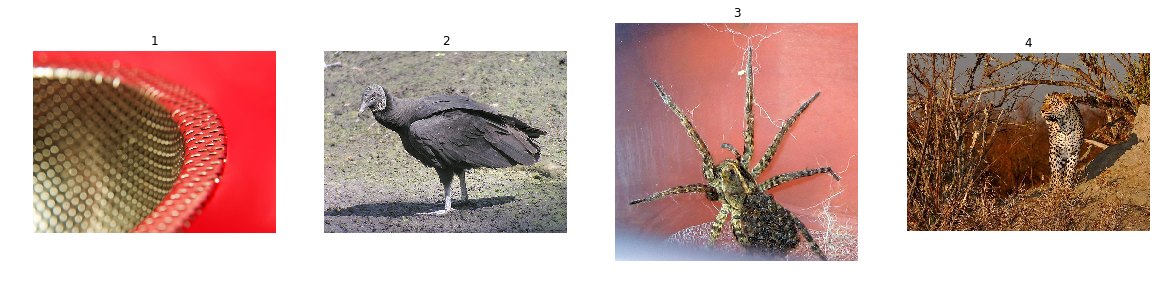

In [4]:
figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(i+1)
    plt.imshow(list_images[i])
    plt.axis('off')
plt.show()

#### Number of categories

In [2]:
dir_path = 'CutMix-PyTorch/imagenet/val'
print(len(os.listdir(dir_path)))

1000


#### Number of images per each category

In [3]:
list_files = []
list_H_sizes = []
list_W_sizes = []
k=0
for path in os.listdir(dir_path):
    new_path = os.path.join(dir_path, path)
    tmp_list = os.listdir(new_path)
    j=0
    for path2 in tmp_list:
        if os.path.isfile(os.path.join(new_path, path2)):
            tmp_pic = cv2.imread(os.path.join(new_path, path2))
            list_W_sizes.append(tmp_pic.shape[0])
            list_H_sizes.append(tmp_pic.shape[1])
            j+=1
    if j==50:
        k+=1
if k==1000:
    print('All 1000 categories has 50 images.')

All 1000 categories has 50 images.


#### Histogram of image sizes in ImageNet

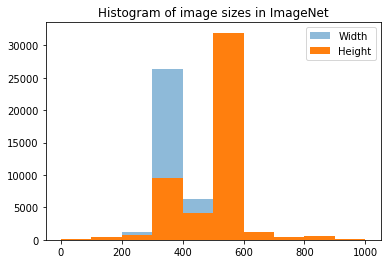

In [15]:
plt.hist(list_W_sizes, range=[0, 1000],alpha=0.5, label='Width')
plt.hist(list_H_sizes,range=[0, 1000], label='Height')
plt.title('Histogram of image sizes in ImageNet')
plt.legend(loc='upper right')
plt.show()

#### Max and min width and Height

In [23]:
print('Max width',np.max(list_W_sizes))
print('Min width',np.min(list_W_sizes))
print('=========')
print('Max height',np.max(list_H_sizes))
print('Min height',np.min(list_H_sizes))

Max width 5005
Min width 56
Max height 4288
Min height 54


#### Percentage of portrait and landscape images

We count images, the width of which is higher than their height as landscape images and vice versa.

In [26]:
h=0
w=0
for i in range(len(list_W_sizes)):
    if list_H_sizes[i]>list_W_sizes[i]:
        h+=1
    else:
        w+=1
print('Percentage of portrait images',h/len(list_W_sizes))
print('Percentage of landscape images',w/len(list_W_sizes))

Percentage of portrait images 0.69524
Percentage of landscape images 0.30476


## Data Augmentation

### 1) Altering the intensities of the RGB channels

We want to perform PCA on RGB pixel values of an image $(I)$. Each image has $X\times Y$ pixels, and each pixel has 3 values. Therefore, the dimension of the images is $X\times Y\times 3$.

$$
I = 
\begin{pmatrix}
I_{0,0} & I_{0,1} & \cdots & I_{0,Y-1} \\
I_{1,0} & I_{1,1} & \cdots & I_{1,Y-1} \\
\vdots & \vdots & \ddots & \vdots \\
I_{X-1,0} & I_{X-1,1} & \cdots & I_{X-1,Y-1} 
\end{pmatrix}
$$
$$
I_{x,y} = {[I^{R}_{x,y},I^{G}_{x,y},I^{B}_{x,y}]}^{T}
$$
$$
x \in [0,1,\cdots,X-1], \quad y \in [0,1,\cdots,Y-1]
$$

Where $I^{R}_{x,y},I^{G}_{x,y},$ and $I^{B}_{x,y}$ shows intensity of the pixel in each cordinate. Now, we want to perform PCA on RGB pixel values of an image $(I)$. We will add this quantity to each pixel:

$$
[p_{1}, p_{2}, p_{3}]{[\alpha_{1}\lambda_{1}, \alpha_{2}\lambda_{2}, \alpha_{3}\lambda_{3}]}^{T}
$$

Where $p_{1}, p_{2},$ and $p_{3}$ are eigenvectors and $\lambda_{1},\lambda_{2}$ and $\lambda_{3}$ are eigenvalue of $3\times 3$ covariance matrix of each pixel with cordinations of $(x,y)$. $\alpha_{1}, \alpha_{2},$ and $\alpha_{3}$ are random variables, drawn from a Gaussian with a mean of zero and a standard deviation of 0.1. Only once for all the pixels of an image, each $\alpha_{i}$ is sampled.

#### Select one of our sample images.

In [5]:
I = list_images[2].astype(float).copy()
print('X for this image: ',I.shape[0])
print('Y for this image: ',I.shape[1])

X for this image:  627
Y for this image:  640


#### Rescale from $[0,255]$ to $[0,1]$ range

In [6]:
I = I / 255.0

#### Flatten the image

We flatten the image matrix $(I)$ with 3 dimensions of $X\times Y\times 3$ and create another matrix $(I^{\prime})$, the two dimensions of which are $(X\times Y)\times 3$

$$
I = 
\begin{pmatrix}
I_{0,0} & I_{0,1} & \cdots & I_{0,Y-1} \\
I_{1,0} & I_{1,1} & \cdots & I_{1,Y-1} \\
\vdots & \vdots & \ddots & \vdots \\
I_{X-1,0} & I_{X-1,1} & \cdots & I_{X-1,Y-1} 
\end{pmatrix} \longrightarrow I^{\prime}={\begin{pmatrix}
I_{0,0} & I_{0,1} & \cdots & I_{0,Y-1} & I_{1,0} & I_{1,1} & \cdots & I_{1,Y-1} & \cdots & I_{X-1,0} & I_{X-1,1} & \cdots & I_{X-1,Y-1}
\end{pmatrix}}^{T}
$$

We flatten the image in order to simplify finding the covariance matrix.

In [7]:
I_prime = I.reshape(-1, 3)
print('Original image dimensions: ',I.shape)
print('Flattened image dimentions: ',I_prime.shape)

Original image dimensions:  (627, 640, 3)
Flattened image dimentions:  (401280, 3)


#### Substracting the mean of each channel
We need to subtract the mean of each channel from the flattened image matrix if we want our PCA works great.

In [8]:
RGB_mean = np.mean(I_prime, axis=0)
I_prime = I_prime - RGB_mean

#### Calculating the covariance matrix

`rowvar` is a parameter, which is False. It means each column represents a variable, while the rows contain observations.

$$
I^{\prime} = 
\begin{pmatrix}
I^{R}_{0,0} & I^{G}_{0,0} & I^{B}_{0,0}\\ 
I^{R}_{0,1} & I^{G}_{0,1} & I^{B}_{0,1} \\
\vdots & \vdots & \vdots \\
I^{R}_{X-1,Y-1} & I^{G}_{X-1,Y-1} & I^{B}_{X-1,Y-1} 
\end{pmatrix}\longrightarrow \text{Cov}(I^{\prime}) = 
\begin{pmatrix}
\text{Var}(R) & \text{Cov}(G,R) & \text{Cov}(B,R)  \\
\text{Cov}(R,G) & \text{Var}(G) & \text{Cov}(B,G)  \\
\text{Cov}(R,B) & \text{Cov}(G,B) & \text{Var}(B)  
\end{pmatrix}\\
$$

Where $\text{Cov}(*)$ calculates covariance of the matrix, and $R, G,$ and $B$ mean red, green, and blue respectively.

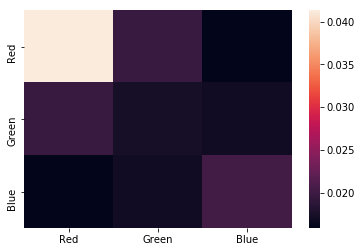

In [9]:
I_cov = np.cov(I_prime, rowvar=False)
labels = ['Red','Green','Blue']
sns.heatmap(I_cov,xticklabels=labels, yticklabels=labels);

It seems Green and Red in this image has a better correlation than other colors.

#### Finding eigenvalues and eigenvectors of the covariance matrix

In [10]:
eig_vals, eig_vecs = np.linalg.eigh(I_cov)
sort_perm = eig_vals[::-1].argsort()
eig_vals[::-1].sort()
eig_vecs = eig_vecs[:, sort_perm]

In [11]:
eig_val, eig_vec = np.linalg.eig(I_cov)

for i in range(len(eig_val)):
    eigvec = eig_vec[:,i].reshape(1,3).T
    
    print('Eigenvector {}: \n{}'.format(i+1, eigvec))
    print('Eigenvalue {}: {}'.format(i+1, eig_val[i]))
    print()

Eigenvector 1: 
[[0.74421681]
 [0.48392294]
 [0.46039106]]
Eigenvalue 1: 0.06394969187089825

Eigenvector 2: 
[[ 0.64692603]
 [-0.35069943]
 [-0.67712378]]
Eigenvalue 2: 0.01405334944341163

Eigenvector 3: 
[[ 0.16621685]
 [-0.80176586]
 [ 0.57405876]]
Eigenvalue 3: 0.0011587138565426708



#### Checking the eigenvector-eigenvalue calculation 

If our eigenvectors and eigenvalues can satisfy this equation, this means we calculated correct values and vectors:
$$
\text{Cov}(I)p_i= \lambda_{i}p_i
$$
$$
i \in [1,2,3]
$$

In [12]:
for i in range(len(eig_vec)):
    eigv = eig_vec[:,i].reshape(1,3).T
    np.testing.assert_array_almost_equal(I_cov.dot(eigv), eig_val[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

#### Visualizing the eigenvectors

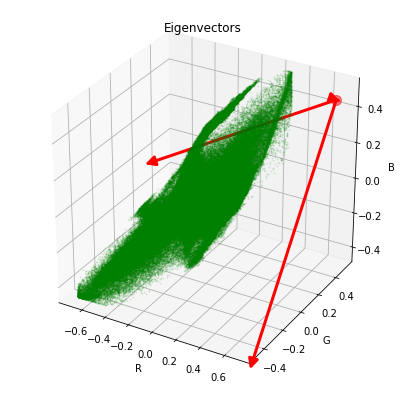

In [13]:


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(I_prime[:,0], I_prime[:,1], I_prime[:,2], 'o', markersize=1, color='green', alpha=0.1)
ax.plot([RGB_mean[0]], [RGB_mean[1]], [RGB_mean[2]], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec.T:
    a = Arrow3D([RGB_mean[0], v[0]], [RGB_mean[1], v[1]], [RGB_mean[2], v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

plt.title('Eigenvectors')

plt.show()

#### Calculating $[p_{1}, p_{2}, p_{3}]$

In [14]:
term1 = np.column_stack((eig_vec))

#### Sample $\alpha_{i}$
As we discussed earlier, $\alpha_{1}, \alpha_{2},$ and $\alpha_{3}$ are random variables, drawn from a Gaussian with a mean of zero and a standard deviation of 0.1.

In [15]:
alpha = np.random.normal(0, 0.1,3)

#### Calculating $[\alpha_{1}\lambda_{1}, \alpha_{2}\lambda_{2}, \alpha_{3}\lambda_{3}]$

In [16]:
term2 = eig_val * alpha

#### Calculating $[p_{1}, p_{2}, p_{3}]{[\alpha_{1}\lambda_{1}, \alpha_{2}\lambda_{2}, \alpha_{3}\lambda_{3}]}^{T}$

In [17]:
add_vect = term1.dot(term2.T)
print('Values that we will add to RGB pixel values of the image: ', add_vect)

Values that we will add to RGB pixel values of the image:  [-0.00185604 -0.00287809 -0.00202373]


#### Final image

In [18]:
for idx in range(3):   # RGB
    I[:,idx] += add_vect[idx]

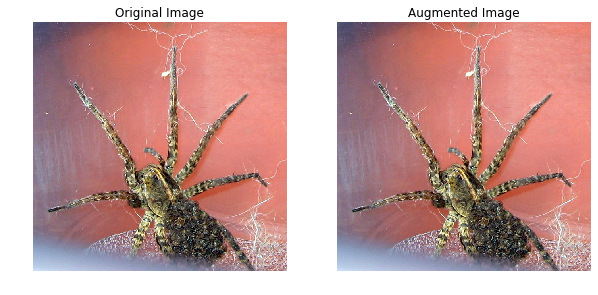

In [19]:
figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(list_images[2])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(I)
plt.axis('off')
plt.show();

We cannot see many differences because of our low sigma (=0.1).

#### Create a function of this augmention method

Because we want to use this augmention method several times, we create a function of it.

In [20]:
def PCA_aug(I, sigma):
    """
    Do PCA on an image
    
    I explained each section in past cells. I put together codes in this function.
    
    Parameters:
        I: Input image
        sigma: The standard deviation that we use for sampling alpha

    RETURN: Augmented image
    """    
    I = I / 255.0
    I_prime = I.reshape(-1, 3)
    RGB_mean = np.mean(I_prime, axis=0)
    I_prime = I_prime - RGB_mean
    I_cov = np.cov(I_prime, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(I_cov)
    sort_perm = eig_vals[::-1].argsort()
    eig_vals[::-1].sort()
    eig_vecs = eig_vecs[:, sort_perm]
    eig_val, eig_vec = np.linalg.eig(I_cov)
    term1 = np.column_stack((eig_vec))
    alpha = np.random.normal(0, sigma,3)
    term2 = eig_val * alpha
    add_vect = term1.dot(term2.T)
    for idx in range(3):   # RGB
        I[:,idx] += add_vect[idx]
    I = I/np.max(I)
    
    return I

#### Try different values for sigma (the standard deviation that we use for sampling $\alpha$)

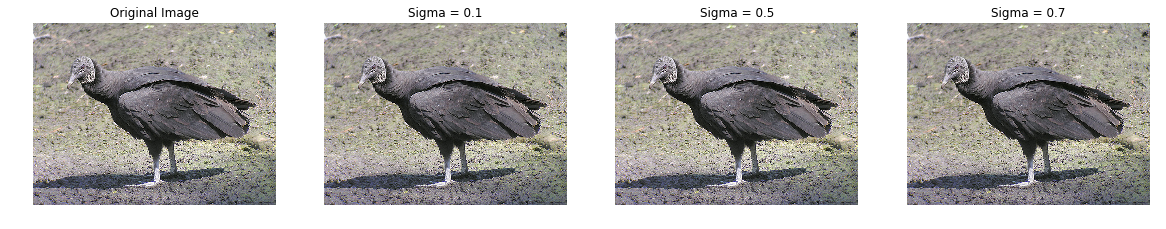

In [21]:
figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(list_images[1])
j=[0.1,0.5,0.7]
for i in range(2,5):
    aug_image = PCA_aug(list_images[1],j[i-2])
    plt.subplot(1, 4, i)
    plt.title('Sigma = ' + str(j[i-2]))
    plt.imshow(aug_image)
    plt.axis('off')
plt.show()

When we increase the sigma, we can see the differences from the original image. It seems that the new image with a sigma of 0.7 has more contrast.

### 2) Image translations (random crops) and horizontal reflection

In this section, we want to crop square images from the original image. For example, we choose the size of $224\times 224$ for cropping.

<img src="pics_notebook/pic_1.png"  width="30%">


For example, the red square is created with the input size. Then, we should select the upper left verticle of the square in green area. In this way, we can assure our square is in the image.
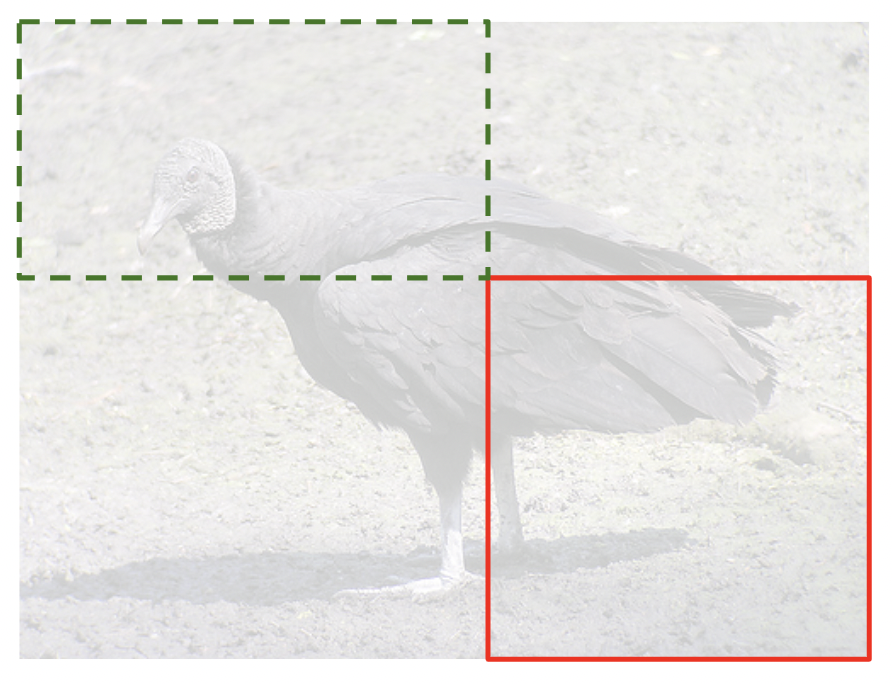

#### Random crops

In [22]:
def random_crop_aug(I, size):
    """
    Crop random square images from the original image
        
    Parameters:
        I: Input image
        size: The standard deviation that we use for sampling alpha

    RETURN: Augmented image
    """    
    max_x = np.max(I.shape[0]-size,0)
    max_y = np.max(I.shape[1]-size,0)
    random_x_y = np.random.randint(0,[max_x,max_y])
    I = I[random_x_y[0]:random_x_y[0]+size,random_x_y[1]:random_x_y[1]+size,:]
    return I

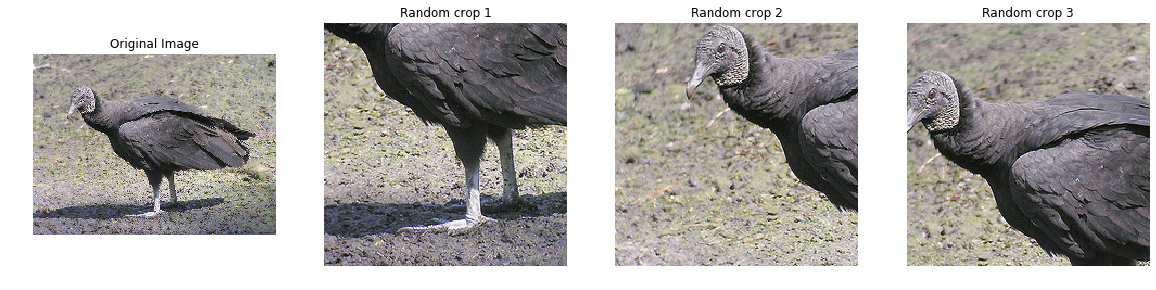

In [23]:
figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(list_images[1])
for i in range(2,5):
    aug_image = random_crop_aug(list_images[1],224)
    plt.subplot(1, 4, i)
    plt.title('Random crop ' + str(i-1))
    plt.imshow(aug_image)
    plt.axis('off')
plt.show()

#### Horizontal reflection

In [24]:
def h_aug(I):
    """
    Flip horizontal an image
        
    Parameters:
        I: Input image
        size: The standard deviation that we use for sampling alpha

    RETURN: Augmented image
    """    
    I = np.fliplr(I)
    return I

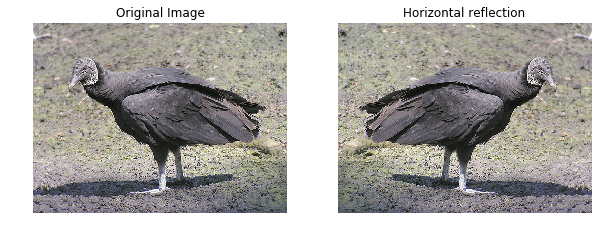

In [25]:
figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(list_images[1])
aug_image = h_aug(list_images[1])
plt.subplot(1, 2, 2)
plt.title('Horizontal reflection')
plt.imshow(aug_image)
plt.axis('off')
plt.show()

### 3) DeepAugmentation

In this section, I will show several data augmentations approaches, which researchers may use to augment their data. 

* `shear`: Shear images by $x$ to $y$ degrees.
* `translate_percent`: When applying affine transformations, new pixels are often generated, e.g. when translating to the left, pixels are generated on the right. Various modes exist to set how these pixels are ought to be filled. Below code shows an example that uses a random brightness between 0 and 255. We depicted two cases:
    * `translate-x`: Translate images by $x\%$ to $y\%$ on x-axis.
    * `translate-y`: Translate images by $x\%$ to $y\%$ on y-axis.
* `sharpen`: sharpens images by adding edges.
* `emboss`: looks like `sharpen`, but the embossed version pronounces highlights and shadows, letting the image look as if it was recreated on a metal plate (“embossed”).
* `coarse-salt-pepper`: Replace rectangular areas in images with white/black-ish pixel noise.
* `brighten`: uses `Add` function, which add a value to all pixels in an image.
* `fog`: executes a single layer per image with a configuration leading to fairly dense clouds with low-frequency patterns.
* `clouds`: executes 1 to 2 layers per image, leading to varying densities and frequency patterns of clouds.
* `invert`: inverts all values in images, i.e. sets a pixel from value $x$ to $1-x$.
* `Dropout`: sets a certain fraction of pixels in images to zero.

In [64]:
def normalize(X):
    return (X/np.max(X)).copy()

def denormalize(X):
    X_dn = (X*255).copy()
    return X_dn

def augment_and_show(X, aug_type, magnitude):
    elif aug_type == "shear":
        X_aug = iaa.Affine(shear=(-90 * magnitude, 90 * magnitude)).augment_image(X)
    elif aug_type == "translate-x":
        X_aug = iaa.Affine(
            translate_percent={
                "x": (-magnitude, magnitude),
                "y": (0, 0)
            }
        ).augment_images(X)
    elif aug_type == "translate-y":
        X_aug = iaa.Affine(
            translate_percent={
                "x": (0, 0),
                "y": (-magnitude, magnitude)
            }
        ).augment_images(X)
    elif aug_type == "sharpen":
        X_aug = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.50, 5 * magnitude)).augment_image(X)
    elif aug_type == "emboss":
        X_aug = iaa.Emboss(alpha=(0, 1.0), strength=(0.0, 20.0 * magnitude)).augment_image(X)
    elif aug_type == "dropout":
        X_aug = iaa.Dropout((0.01, max(0.011, magnitude)), per_channel=0.5).augment_image(X) # Dropout first argument should be smaller than second one
    elif aug_type == "brighten":
        X_aug = iaa.Add((int(-40 * magnitude), int(40 * magnitude)), per_channel=0.5).augment_image(X) # brighten
    elif aug_type == "invert":
        X_aug = iaa.Invert(1.0).augment_image(X) # magnitude not used
    elif aug_type == "fog":
        X_aug = iaa.Fog().augment_image(X) # magnitude not used
    elif aug_type == "clouds":
        X_aug = iaa.Clouds().augment_image(X) # magnitude not used
    elif aug_type == "super-pixels": # deprecated
        X_norm = normalize(X)
        X_norm2 = (X_norm*2)-1
        X_aug_norm2 = iaa.Superpixels(p_replace=(0, magnitude), n_segments=(100, 100)).augment_image(X_norm2)
        X_aug_norm = (X_aug_norm2+1)/2
        X_aug = denormalize(X_aug_norm)
    elif aug_type == "snow":
        X_aug = iaa.Snowflakes().augment_image(X)
    elif aug_type == "coarse-salt-pepper":
        X_aug = iaa.CoarseSaltAndPepper(p=0.2, size_percent=magnitude).augment_image(X)
    else:
        raise ValueError
    return X_aug

/projects/reak3132/software/anaconda/envs/torch35/lib/python3.5/site-packages/imgaug/augmenters/base.py:38: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (375, 500, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  category=SuspiciousMultiImageShapeWarning)


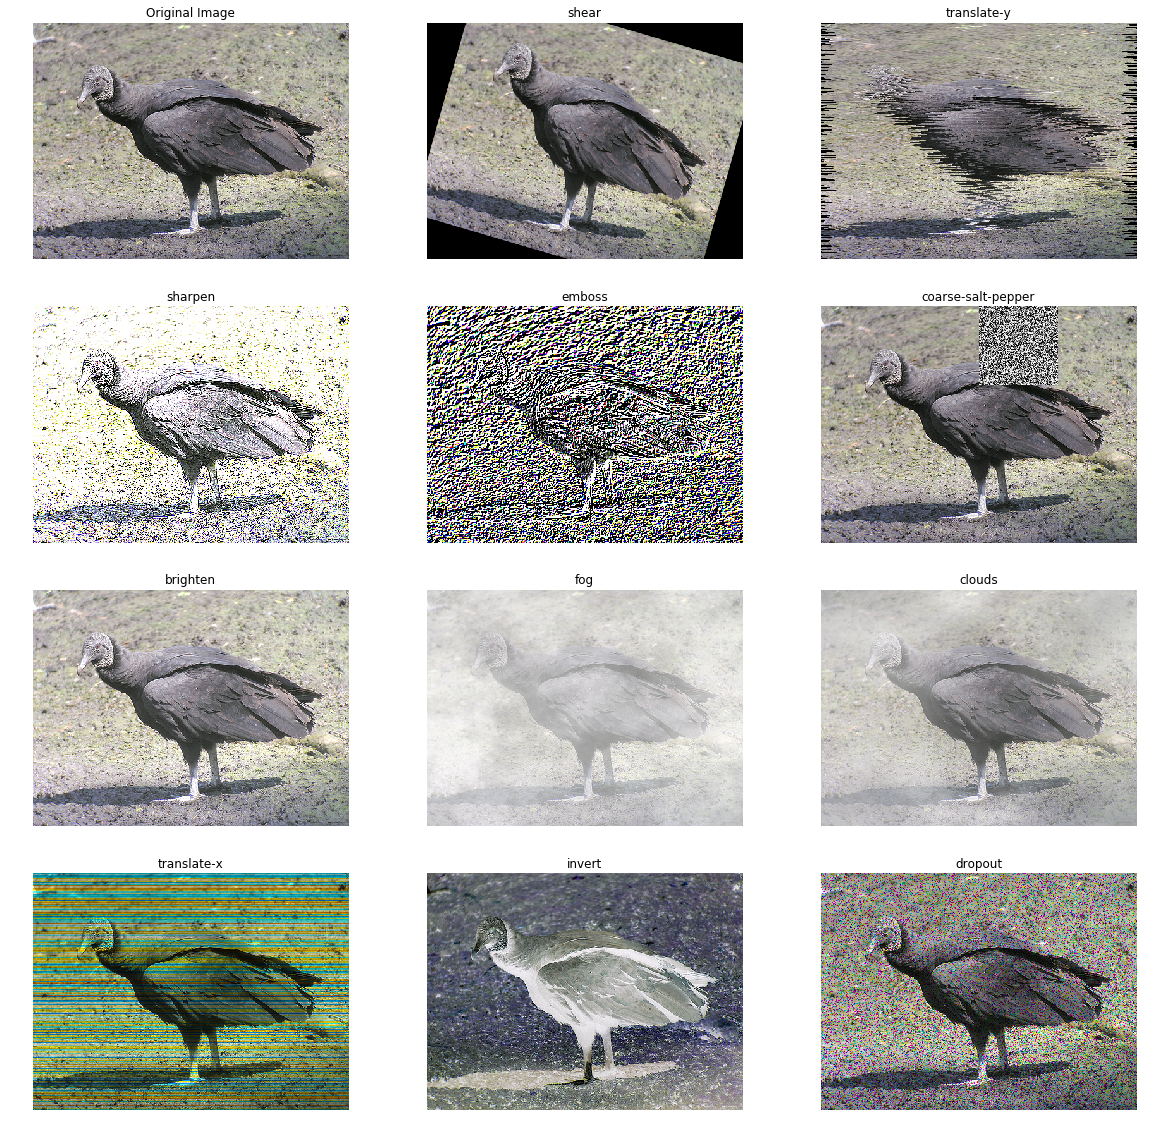

In [67]:
figure(figsize=(20, 20))
plt.subplot(4, 3, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(list_images[1])
aug_method=[("shear", 0.6), ("translate-y", 0.05), ("sharpen", 2), ("emboss", 1.0),
           ("coarse-salt-pepper",0.01), ("brighten", 3.0), ("fog", 1.0), ("clouds", 1.0),
           ("translate-x", 0.5), ("invert", 1.0), ("dropout", 0.2),("snow",0)]
for i in range(2,13):
    aug_image = augment_and_show(list_images[1],aug_method[i-2][0],aug_method[i-2][1])
    plt.subplot(4, 3, i)
    plt.title(aug_method[i-2][0])
    plt.imshow(aug_image)
    plt.axis('off')
plt.show()

### 4) CutMix

Here, I want to implement one of the state-of-the-art methods for data augmention. I just wanted to show how the final image is in this method. However, the authors of that article create a new label with this idea for the generated image.

In [138]:
I_1 = list_images[1].copy()
X=list_images[1].shape[0]
Y=list_images[1].shape[1]

In order to do CutMix, we need two image with the same size.

In [139]:
I_2 = cv2.resize(list_images[3], dsize=(Y,X), interpolation=cv2.INTER_CUBIC)

Let $I_1$ and $I_2$ are images and $y_1$ and $y_2$ are labels respectively. The main goal of CutMix is to generate a new training sample $(\tilde{I}, \tilde{y})$ by combining those training samples. We can use these generated images and labels as additional data for training the models. They defined the combining operation as:

$$
\tilde{I} =\boldsymbol{\text{M}} \odot I_1 + (\boldsymbol{1} - \boldsymbol{\text{M}}) \odot I_2
$$
$$
\tilde{y} = \lambda y_1 + (1-\lambda) y_2
$$

where $\boldsymbol{\text{M}} ∈ {\{0, 1\}}^{\text{X}\times\text{Y}}$ denotes a binary mask indicating where to drop out and fill in from two images, $\boldsymbol{1}$ is a binary mask filled with ones, and  is element-wise multiplication.
The combination ratio $\lambda$ between two data points is sampled from the beta distribution $\text{Beta}(\alpha, \alpha)$. In
their experiments, they set $\alpha$ to 1, that is $\lambda$ is sampled from the uniform distribution (0, 1).

#### Sample $\lambda$ and copy originial image to another variable

In [140]:
I_3 = I_1.copy()
l = np.random.rand(1) 

To sample the binary mask $\boldsymbol{\text{M}}$, we first sample the bounding box coordinates $B = (r_x, r_y, r_w, r_h)$ indicating the cropping regions on $I_1$ and $I_2$. The region $B$ in $I_1$ is removed and filled in with the patch cropped from B of $I_2$. In their experiments, they sample rectangular masks $\boldsymbol{\text{M}}$ whose aspect ratio is proportional to the original image. The box coordinates are uniformly sampled according to:

$$
r_x \sim \text{Uniform} (0,X), \quad r_w = X\sqrt{1-\lambda}
$$
$$
r_y \sim \text{Uniform} (0,Y), \quad r_h = Y\sqrt{1-\lambda}
$$

making the cropped area ratio $\frac{r_w r_h}{WH} = 1−\lambda$. With the cropping region, the binary mask $\boldsymbol{\text{M}} \in {\{0, 1\}}^{X\times Y}$ is decided by filling with 0 within the bounding box $B$, otherwise 1.

#### Sample the binary mask $\boldsymbol{\text{M}}$

In [141]:
r_x = np.random.rand(1)*X
r_y = np.random.rand(1)*Y
r_w = X*np.sqrt(1-l)
r_h = Y*np.sqrt(1-l)
x1 = int(np.round(np.clip(r_x-r_w//2,0,X))[0])
x2 = int(np.round(np.clip(r_x+r_w//2,0,Y))[0])
y1 = int(np.round(np.clip(r_y-r_h//2,0,X))[0])
y2 = int(np.round(np.clip(r_y+r_h//2,0,Y))[0])
print(x1,x2,y1,y2)

0 197 0 347


#### Adjust lambda to exactly match pixel ratio $\frac{r_w r_h}{WH} = 1−\lambda$

In [142]:
l = 1 - (x2-x1)*(y2-y1)/(X*Y) 
print('Lambda is ',l)

Lambda is  0.6354186666666667


#### $\tilde{I} =\boldsymbol{\text{M}} \odot I_1 + (\boldsymbol{1} - \boldsymbol{\text{M}}) \odot I_2$

In [143]:
I_3[x1:x2, y1:y2,:] = I_2[x1:x2, y1:y2,:]
I_3 = l * I_3 + (1 - l) * I_2

#### Normalize the image

In [144]:
I_3 = (I_3-np.min(I_3))/(np.max(I_3)-np.min(I_3))

#### Plotting the final image

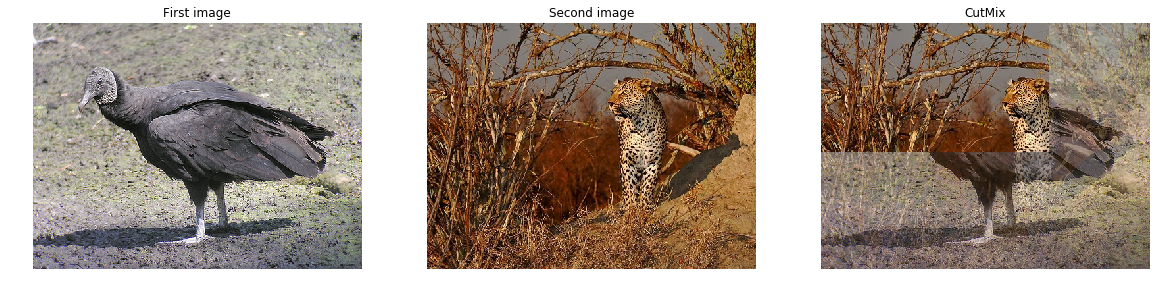

In [145]:
figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('First image')
plt.imshow(I_1)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Second image')
plt.imshow(I_2)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('CutMix')
plt.imshow(I_3)
plt.axis('off')
plt.show()

In this method, in order to calculate the loss for generated images, we should calculate the following equation:

$$
\text{Final loss} = \text{Loss}(\hat{y}, y_1)\lambda + \text{Loss}(\hat{y}, y_2)(1-\lambda)
$$

where $\hat{y}$ is the output of the model and $\text{Loss}(*,*)$ calculates the loss based on its inputs.

### 5) MixUp

They introduce a simple and data-agnostic data augmentation routine, termed MixUp. In a nutshell, mixup constructs virtual training examples:

$$
\tilde{I} = \lambda I_1 + (1-\lambda) I_2
$$
$$
\tilde{y} = \lambda y_1 + (1-\lambda) y_2
$$

where $I_1$ and $I_2$ are images and $y_1$ and $y_2$ are labels respectively and $\lambda \in [0,1]$, which is selected like CutMix. In this section, I will show how MixUp method works. I will try it with two example images. 

In order to do CutMix, we need two image with the same size.

In [146]:
I_1 = list_images[1].copy()
I_3 = list_images[1].copy()

In [147]:
I_2 = cv2.resize(list_images[3], dsize=(Y,X), interpolation=cv2.INTER_CUBIC)

In [148]:
alpha = 0.2
l = np.random.beta(alpha, alpha, size=[1])

I_3 = I_3[::-1] * l + I_3 * (I_2 - l)

I_3 = (I_3-np.min(I_3))/(np.max(I_3)-np.min(I_3))

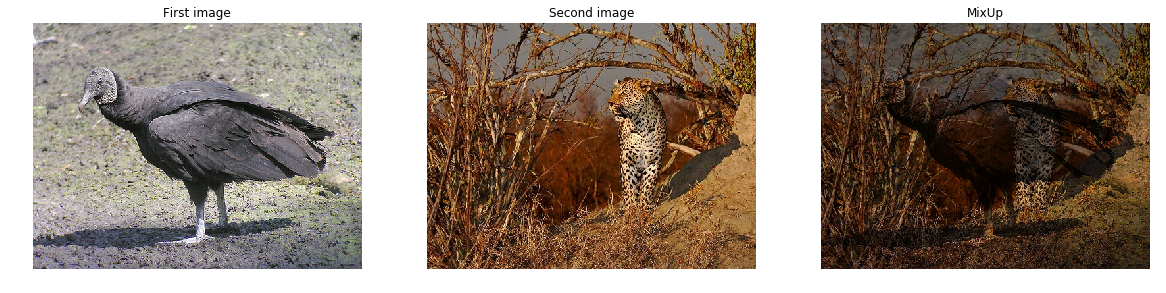

In [149]:
figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('First image')
plt.imshow(I_1)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Second image')
plt.imshow(I_2)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('MixUp')
plt.imshow(I_3)
plt.axis('off')
plt.show()

Like the past method, we should calculate loss as below:

$$
\text{Final loss} = \text{Loss}(\hat{y}, y_1)\lambda + \text{Loss}(\hat{y}, y_2)(1-\lambda)
$$

where $\hat{y}$ is the output of the model and $\text{Loss}(*,*)$ calculates the loss based on its inputs.

## Evaluation of Baseline, MixUp, and CutMix

In this section, we use implemented codes by the authors of CutMix. For running the codes, first of all, you should download the validation dataset of ImageNet. Then, clone the code of CutMix and download the pre-trained models.

1. clone the GitHub repository:
    
    git clone https://github.com/clovaai/CutMix-PyTorch.git
    
2. Download the images from http://image-net.org/download-images
3. Extract the validation data and move images to subfolders:
    
    
    mkdir val && mv ILSVRC2012_img_val.tar val/ && cd val && tar -xvf ILSVRC2012_img_val.tar
    wget -qO- https://raw.githubusercontent.com/soumith/imagenetloader.torch/master/valprep.sh | bash
    
    
4. Download these pre-trained models:
    
    * Baseline (ResNet-50): https://www.dropbox.com/sh/phwbbrtadrclpnx/AAA9QUW9G_xvBdI-mDiIzP_Ha?dl=0 (models/baseline)
    * MixUp: https://www.dropbox.com/sh/g64c8bda61n12if/AACyaTZnku_Sgibc9UvOSblNa?dl=0 (models/mixup)
    * CutMix: https://www.dropbox.com/sh/w8dvfgdc3eirivf/AABnGcTO9wao9xVGWwqsXRala?dl=0 (models/cutmix)


### Baseline

In [2]:
!python CutMix-PyTorch/test.py --net_type resnet --dataset imagenet --batch_size 64 --depth 50 --pretrained CutMix-PyTorch/models/baseline/model_best.pth.tar

==========  782
=> creating model 'resnet'
=> loading checkpoint 'CutMix-PyTorch/models/baseline/model_best.pth.tar'
=> loaded checkpoint 'CutMix-PyTorch/models/baseline/model_best.pth.tar'
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(

### MixUp

In [3]:
!python CutMix-PyTorch/test.py --net_type resnet --dataset imagenet --batch_size 64 --depth 50 --pretrained CutMix-PyTorch/models/mixup/model_best.pth.tar

==========  782
=> creating model 'resnet'
=> loading checkpoint 'CutMix-PyTorch/models/mixup/model_best.pth.tar'
=> loaded checkpoint 'CutMix-PyTorch/models/mixup/model_best.pth.tar'
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),

### CutMix

In [4]:
!python CutMix-PyTorch/test.py --net_type resnet --dataset imagenet --batch_size 64 --depth 50 --pretrained CutMix-PyTorch/models/cutmix/model_best.pth.tar

==========  782
=> creating model 'resnet'
=> loading checkpoint 'CutMix-PyTorch/models/cutmix/model_best.pth.tar'
=> loaded checkpoint 'CutMix-PyTorch/models/cutmix/model_best.pth.tar'
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1

### Results

Model | Top-1 Error | Top-5 Error
--- | --- | ---
ResNet-50 (Baseline) | 23.676 | 7.05
ResNet-50 + MixUp | 22.528 | 6.4
ResNet-50 + CutMix | **21.4** | **5.924**

We can observe ResNet-50 + CutMix outperform other models

## Conclusion
* Altering the intensities of the RGB channels with PCA, images will be changed very smoothly. We can set a higher sigma for sampling $\alpha$ to see more changes.
* The validation dataset of ImageNet is balanced, and we have 50 images for each category. Also, most of images are portrait. 
* By evaluating 3 models on ImageNet, we can find out that ResNet-50 + CutMix did better than other models.
* Although CutMix and MixUp are simple methods, we can see how much they can improve the performance. 
* We have so many data augmentation methods, but I did not have time to explore most of them. Also, we can apply them at the same time. 



## Resources
* https://arxiv.org/pdf/1905.04899.pdf
* https://arxiv.org/pdf/1710.09412.pdf
* https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
* https://sebastianraschka.com/Articles/2014_pca_step_by_step.html
* https://github.com/barisozmen/deepaugment